### No air drag or wind effects

$$
\dot{\vec{v}} = -g\hat{y}
$$

The range $R_{\rm vac}$ of flight in this vacuum environment is
$$
R_{\rm vac} = \frac{v_0 \sin\left( 2 \theta_0 \right)}{g}.
$$

For example, if $v_0 = 200\,{\rm m\ s^{-1}}$, $\theta_0 = 45^\circ$, and $g = 3.721\,{\rm m\ s^{-2}}$, so
$$
R_{\rm vac} = \frac{\left( 200\,{\rm m\ s^{-1}} \right) \sin\left( 2 \left(  45^\circ \right) \right)}{3.721\,{\rm m\ s^{-2}}} = 54\,{\rm m}.
$$

### Air drag but no wind effects

$$
\dot{\vec{v}} = -g\hat{y} - \left( \frac{C_{\rm D} \rho_{\rm air} A}{m} \right) v^2 \hat{v},
$$
where $C_{\rm D}$ is the drag coefficient for the ejecta particle ($\approx 1$), $\rho_{\rm air}$ is the density of the air ($\approx 0.02\,{\rm kg\ m^{-3}}$), $A$ is the cross-sectional area of the particle, and $m$ is its mass.

The solution for this problem is cast in terms of the terminal velocity $v_{\rm term}$:
$$
v_{\rm term} = \sqrt{\frac{m g}{C_{\rm D} \rho_{\rm air} A}}.
$$

For a sand grain of $2\,{\rm mm}$ radius and density $3000\,{\rm kg\ m^{-3}}$, 
$$
v_{\rm term} = \sqrt{\frac{\left( 10^{-4}\,{\rm kg} \right) \left( 3.721\,{\rm m\ s^{-2}} \right)  }{\left( 0.02\,{\rm kg\ m^{-3}} \right) \pi \left( 2\,{\rm mm} \right)^2 }} = 38\,{\rm m\ s^{-1}}.
$$

So the new range including air drag but no wind is
$$
R_{\rm drag} = R_{\rm vac} \left( 1 - \frac{3 v_0\sin \theta}{v_{\rm term}} \right).
$$

So for the same dust particle and launch conditions as above:
$$
R_{\rm drag} = \left( 54\,{\rm m} \right) \left( 1 - \frac{3 \left( 200\,{\rm m\ s^{-1}} \right) \sin \left( 45^\circ \right) }{38\,{\rm m\ s^{-1}}} \right) = 11\,{\rm m}.
$$

The fact that these range estimates are so small compared the actual distance traveled by the ejecta patterns suggest that the ejecta *must* have been carried by wind.

### Air drag and wind

Near the surface, wind speeds $u$ as a function of altitude $z$ are given by the Law of the Wall:
$$
u(z) = \frac{u_\star}{\kappa} \ln \left( \frac{z}{z_0} \right),
$$
with $\kappa \approx 0.4$.

In order to figure out how far downstream the ejecta are carried, we need to figure out how high the ejecta are thrown.

$$
\dot{\vec{v}} = -g\hat{y} - \left( \frac{C_{\rm D} \rho_{\rm air} A}{m} \right) v^2 \hat{v},
$$

Re-scale by dividing through by $g$:
$$
\dot{v}^\prime = \frac{\dot{v}}{g}\\ 
v^\prime = \frac{v}{v_{\rm term}}\\
x^\prime = \frac{v_{\rm term}^2}{g}\\
t^\prime = \frac{v_{\rm term}}{g} 
$$

$$
\dot{\vec{v}^\prime} = -\hat{y} - v^{\prime\ 2} \hat{v} = -\hat{y} - \left( v_x^{\prime\ 2} + v_y^{\prime\ 2} \right)\hat{v}.
$$

Let's start by numerically integrating the equations of motion and not including any winds.

In [34]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint, cumtrapz

In [62]:
def calc_vprime(vx, vy):
    return np.sqrt(vx*vx + vy*vy)

def v_dot(v_vec, t):
    vx, vy = v_vec
    vprime = calc_vprime(vx, vy)
    vhat_x = vx/vprime
    vhat_y = vy/vprime
    
    # Retun the x-hat and y-hat components
    return -vprime*vprime*vhat_x, -1. - vprime*vprime*vhat_y

0.020053368632749858


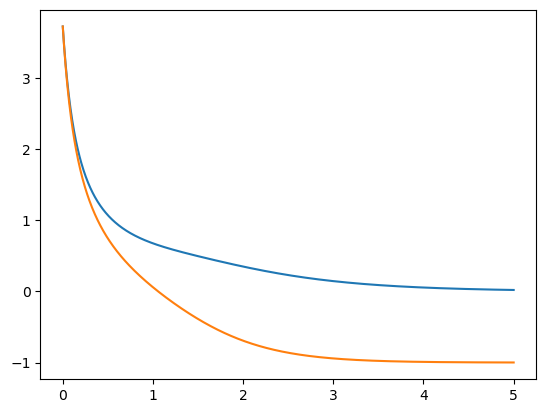

In [63]:
v0 = (200./38) # 200 m/s / 38 m/s
theta = 45.*np.pi/180. # 45-deg launch
vx = v0*np.cos(theta)
vy = v0*np.sin(theta)
v0_vec = np.array([vx, vy])

t = np.linspace(0, 5., 1000)
res = odeint(v_dot, v0_vec, t)

plt.plot(t, res[:,0])
plt.plot(t, res[:,1])

print(res[-1,0])

(0.0, 2.042775241726934)

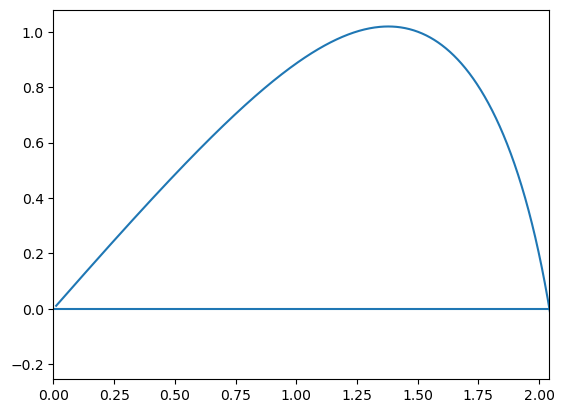

In [50]:
x = cumtrapz(res[:,0], t)
y = cumtrapz(res[:,1], t)

plt.plot(x, y)
plt.axhline(0)

ind = np.argmin(np.abs(y))
plt.xlim([0, x[ind]])

Now let's include a wind profile with
$$
u^\prime(y^\prime) = \frac{u_\star^\prime}{\kappa} \ln \left( \frac{y^\prime}{z_0^\prime} \right).
$$

$$
\dot{\vec{v}^\prime} = -\hat{y} - \left( \left( v_x^\prime - u^\prime \right)^2 + v_y^{\prime\ 2} \right)\hat{v}.
$$

In [140]:
def wind_velocity(y, ustar_prime=1./34., z0_prime=1e-2/(34.*34/3.712), kappa=0.4):
    # z0 ~ 1 cm
    # ustar ~ 1 m/s -> u(z = 1 m) ~ 10 m/s
    
    if(y < z0_prime):
        return 0.
    else:
        return (ustar_prime/kappa)*np.log(y/z0_prime)

def calc_vprime(vx_prime, vy_prime, y_prime, ustar_prime=1./34.):

    u_prime = wind_velocity(y_prime, ustar_prime=ustar_prime)
    delta_vx_prime = vx_prime - u_prime
    
    return np.sqrt(delta_vx_prime*delta_vx_prime + vy*vy)

def dot(vec, t, ustar_prime=1./34):    
    x, y = vec[0], vec[1]
    vx_prime, vy_prime = vec[2], vec[3]
    
    vprime = calc_vprime(vx_prime, vy_prime, y, ustar_prime=ustar_prime)
    
    vx_hat = vx_prime/vprime
    vy_hat = vy_prime/vprime
    
    return vx_prime, vy_prime, -vprime*vprime*vx_hat, -1. - vprime*vprime*vy_hat

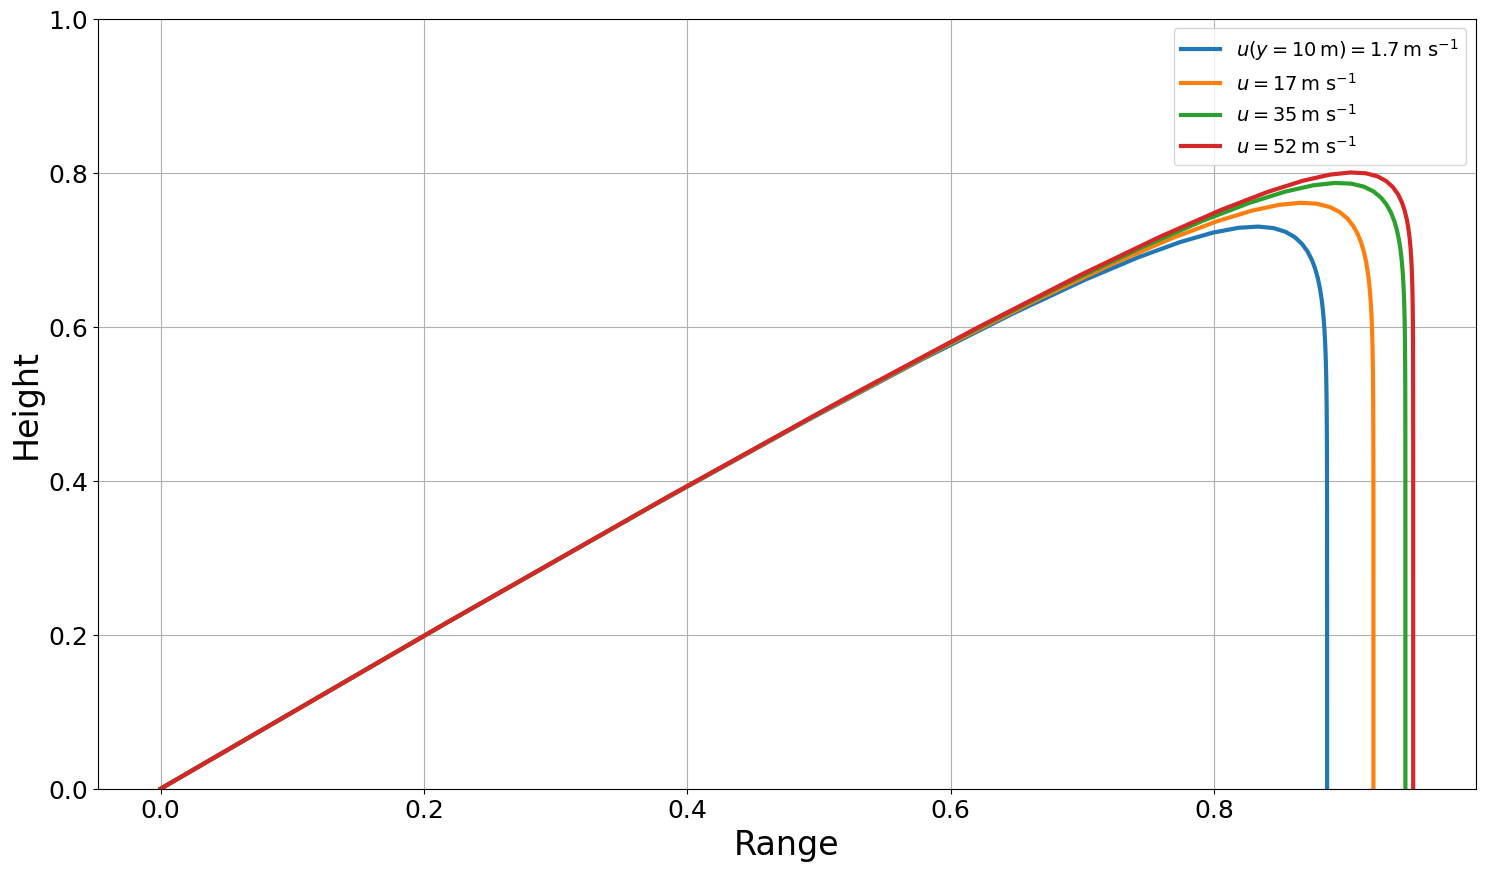

In [168]:
fig = plt.figure(figsize=(10*16./9, 10))
ax = fig.add_subplot(111)

v0 = (200./34) # 200 m/s / 38 m/s
theta = 45.*np.pi/180. # 45-deg launch
x = 0.
y = 0.
vx = v0*np.cos(theta)
vy = v0*np.sin(theta)
vec = np.array([x, y, vx, vy])
t = np.linspace(0, 6., 100)

ustar_prime = 0.1
res = odeint(dot, vec, t, args=(ustar_prime/34.,))
uz = wind_velocity(10., ustar_prime=ustar_prime, z0_prime=1e-2, kappa=0.4)
ax.plot(res[:,0], res[:,1], lw=3, label=r'$u(y = 10\,{\rm m}) = %0.2g\,{\rm m\ s^{-1}}$' % uz)

ustar_prime = 1.
res = odeint(dot, vec, t, args=(ustar_prime/34.,))
uz = wind_velocity(10., ustar_prime=ustar_prime, z0_prime=1e-2, kappa=0.4)
ax.plot(res[:,0], res[:,1], lw=3, label=r'$u = %0.2g\,{\rm m\ s^{-1}}$' % uz)

ustar_prime = 2.
res = odeint(dot, vec, t, args=(ustar_prime/34.,))
uz = wind_velocity(10., ustar_prime=ustar_prime, z0_prime=1e-2, kappa=0.4)
ax.plot(res[:,0], res[:,1], lw=3, label=r'$u = %0.2g\,{\rm m\ s^{-1}}$' % uz)

ustar_prime = 3.
res = odeint(dot, vec, t, args=(ustar_prime/34.,))
uz = wind_velocity(10., ustar_prime=ustar_prime, z0_prime=1e-2, kappa=0.4)
ax.plot(res[:,0], res[:,1], lw=3, label=r'$u = %0.2g\,{\rm m\ s^{-1}}$' % uz)

ax.set_xlabel('Range', fontsize=24)
ax.set_ylabel('Height', fontsize=24)
ax.tick_params(labelsize=18)
ax.grid(True)
ax.set_ylim([0, 1.])
ax.legend(loc='best', fontsize=14)

# plt.plot(t, res[:,2])
# plt.axhline(wind_velocity(np.max(res[:,1])))

# plt.plot(res[:,0], res[:,2])
# plt.axhline(vx)
# plt.axhline(wind_velocity(np.max(res[:,1])))

# fig.savefig("Range_vs_Height.png", dpi=300, bbox_inches="tight")